In [ ]:
# Import necessary packages

import pandas as pd
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from scipy.stats import loguniform
from scipy.stats import uniform
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer

import xgboost as xgb

In [ ]:
# Silence warnings

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load The Datasets

df_dev = pd.read_csv("dev.csv")
df_test = pd.read_csv("test.csv")

print("Dataset Shapes \n")
print("- Development Set: {}".format(df_dev.shape))
print("- Test Set: {}".format(df_test.shape))

Dataset Shapes 

- Development Set: (77930, 28)
- Test Set: (19483, 28)


In [ ]:
# Split into features

dev_x, dev_y = df_dev.drop(columns=["total_points"]), df_dev["total_points"]
test_x, test_y = df_test.drop(columns=["total_points"]), df_test["total_points"]

# Linear Regression

In [ ]:
# Categorical Variable Handling: One Hot Encoding

# Numerical features
num_features = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'minutes', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'selected', 'team_a_score', 'team_h_score',
       'threat', 'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards']

# Identify the categorical features to one-hot encode later on (linear regression models can't handle categorical data)
cat_features = ['position']

# See if there are any positions missing in dev that are not in test
print("Positions in development: {}".format(df_dev['position'].unique()))
print("Positions in test: {}".format(df_test['position'].unique()))

# One-hot encoding (handle_unknown because there are no missing positions)
ohe_preprocess = make_column_transformer((StandardScaler(), num_features), 
                                         (OneHotEncoder(), cat_features)
                                        )

Positions in development: ['MID' 'FWD' 'DEF' 'GK']
Positions in test: ['MID' 'DEF' 'FWD' 'GK']


In [ ]:
# Categorical Variable Handling: Target Encoding

# Numerical features
num_features = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'minutes', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'selected', 'team_a_score', 'team_h_score',
       'threat', 'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards']

# Identify the categorical features to one-hot encode later on (linear regression models can't handle categorical data)
cat_features = ['position']

# See if there are any positions missing in dev that are not in test
print("Positions in development: {}".format(df_dev['position'].unique()))
print("Positions in test: {}".format(df_test['position'].unique()))

te_preprocess = make_column_transformer((StandardScaler(), num_features), 
                                        (TargetEncoder(), cat_features)
                                       )


Positions in development: ['MID' 'FWD' 'DEF' 'GK']
Positions in test: ['MID' 'DEF' 'FWD' 'GK']


Best Alpha Value: 0.7180927872729465
Training MSE: 5.34533342728496
Test MSE: 5.209041071260159
Test MAE (ie. on average how much is our prediction of score off by): 1.3767476512706056


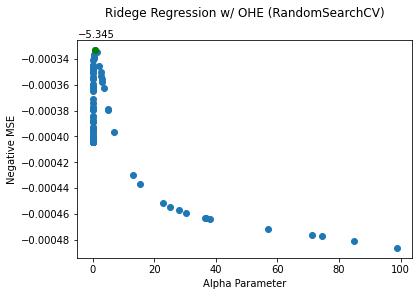

In [ ]:
# RIDGE, OHE

# Set up search space for alphas
search_space = dict()
search_space['alpha'] = loguniform(1e-5, 100)

# Pipeline
ohe_pipe = make_pipeline(ohe_preprocess, 
                         RandomizedSearchCV(Ridge(), search_space, n_iter=100, scoring='neg_mean_squared_error')
                        )

# Fit the model
ohe_pipe.fit(dev_x, dev_y)

# Get the results of the random search
params, mean_test_score = ohe_pipe[1].cv_results_['params'], ohe_pipe[1].cv_results_['mean_test_score']
params = [x['alpha'] for x in params]

# Visualize the results of the random search
plt.scatter(params, mean_test_score)
plt.scatter(ohe_pipe[1].best_estimator_.alpha, ohe_pipe[1].best_score_, color="green")
plt.title('Ridege Regression w/ OHE (RandomSearchCV)', y=1.08)
plt.xlabel('Alpha Parameter')
plt.ylabel('Negative MSE')

# Get the best esimator from the random search
model = ohe_pipe[1].best_estimator_

# Create the best pipeline
best_pipe = make_pipeline(ohe_preprocess, ohe_pipe[1].best_estimator_)

print("Best Alpha Value: {}".format(ohe_pipe[1].best_estimator_.alpha))
print("Training MSE: {}".format(-1*ohe_pipe[1].best_score_))
print("Test MSE: {}".format(mean_squared_error(test_y, best_pipe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}".format(mean_absolute_error(test_y, best_pipe.predict(test_x))))

# Save the model
ohe_ridge_best_pipe = make_pipeline(ohe_preprocess, ohe_pipe[1].best_estimator_)

Best Alpha Value: 1.0305259751652347
Training MSE: 5.346935989072105
Test MSE: 5.210012382068994
Test MAE (ie. on average how much is our prediction of score off by): 1.3780498913531383


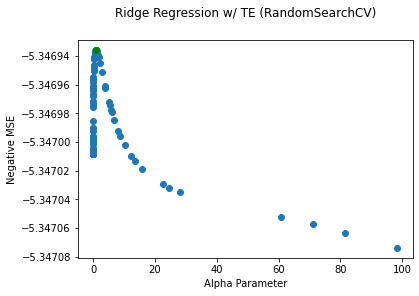

In [ ]:
# RIDGE, TE

# Set up search space for alphas
search_space = dict()
search_space['alpha'] = loguniform(1e-5, 100)

# Pipeline
te_pipe = make_pipeline(te_preprocess, 
                         RandomizedSearchCV(Ridge(), search_space, n_iter=100, scoring='neg_mean_squared_error')
                        )

# Fit the model
te_pipe.fit(dev_x, dev_y)

# Get the results of the random search
params, mean_test_score = te_pipe[1].cv_results_['params'], te_pipe[1].cv_results_['mean_test_score']
params = [x['alpha'] for x in params]

# Visualize the results of the random search
plt.scatter(params, mean_test_score)
plt.scatter(te_pipe[1].best_estimator_.alpha, te_pipe[1].best_score_, color="green")
plt.title('Ridge Regression w/ TE (RandomSearchCV)', y=1.08)
plt.xlabel('Alpha Parameter')
plt.ylabel('Negative MSE')

# Get the best esimator from the random search
model = te_pipe[1].best_estimator_

# Create the best pipeline
best_pipe = make_pipeline(te_preprocess, te_pipe[1].best_estimator_)

print("Best Alpha Value: {}".format(te_pipe[1].best_estimator_.alpha))
print("Training MSE: {}".format(-1*te_pipe[1].best_score_))
print("Test MSE: {}".format(mean_squared_error(test_y, best_pipe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}".format(mean_absolute_error(test_y, best_pipe.predict(test_x))))

# Save the model
te_ridge_best_pipe = make_pipeline(te_preprocess, te_pipe[1].best_estimator_)

Best Alpha Value: 0.0005809855079265689
Training MSE: 5.34545427273827
Test MSE: 5.209082893017849
Test MAE (ie. on average how much is our prediction of score off by): 1.3769911595881619


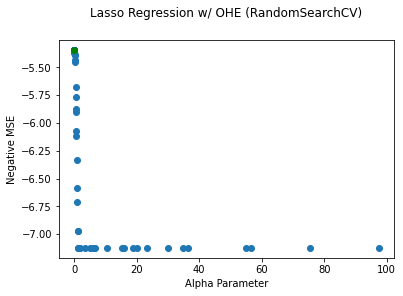

In [ ]:
# LASSO, OHE

# Set up search space for alphas
search_space = dict()
search_space['alpha'] = loguniform(1e-5, 100)

# Pipeline
ohe_pipe = make_pipeline(ohe_preprocess, 
                         RandomizedSearchCV(Lasso(), search_space, n_iter=100, scoring='neg_mean_squared_error')
                        )

# Fit the model
ohe_pipe.fit(dev_x, dev_y)

# Get the results of the random search
params, mean_test_score = ohe_pipe[1].cv_results_['params'], ohe_pipe[1].cv_results_['mean_test_score']
params = [x['alpha'] for x in params]

# Visualize the results of the random search
plt.scatter(params, mean_test_score)
plt.scatter(ohe_pipe[1].best_estimator_.alpha, ohe_pipe[1].best_score_, color="green")
plt.title('Lasso Regression w/ OHE (RandomSearchCV)', y=1.08)
plt.xlabel('Alpha Parameter')
plt.ylabel('Negative MSE')

# Get the best esimator from the random search
model = ohe_pipe[1].best_estimator_

# Create the best pipeline
best_pipe = make_pipeline(ohe_preprocess, ohe_pipe[1].best_estimator_)

print("Best Alpha Value: {}".format(ohe_pipe[1].best_estimator_.alpha))
print("Training MSE: {}".format(-1*ohe_pipe[1].best_score_))
print("Test MSE: {}".format(mean_squared_error(test_y, best_pipe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}".format(mean_absolute_error(test_y, best_pipe.predict(test_x))))

# Save the model
ohe_lasso_best_pipe = make_pipeline(ohe_preprocess, ohe_pipe[1].best_estimator_)

Best Alpha Value: 0.0004071504409505566
Training MSE: 5.34703442917441
Test MSE: 5.210098916810094
Test MAE (ie. on average how much is our prediction of score off by): 1.3781544997098214


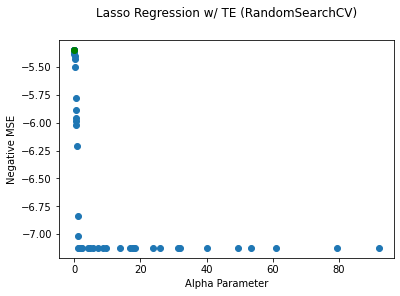

In [ ]:
# LASSO, TE

# Set up search space for alphas
search_space = dict()
search_space['alpha'] = loguniform(1e-5, 100)

# Pipeline
te_pipe = make_pipeline(te_preprocess, 
                         RandomizedSearchCV(Lasso(), search_space, n_iter=100, scoring='neg_mean_squared_error')
                        )

# Fit the model
te_pipe.fit(dev_x, dev_y)

# Get the results of the random search
params, mean_test_score = te_pipe[1].cv_results_['params'], te_pipe[1].cv_results_['mean_test_score']
params = [x['alpha'] for x in params]

# Visualize the results of the random search
plt.scatter(params, mean_test_score)
plt.scatter(te_pipe[1].best_estimator_.alpha, te_pipe[1].best_score_, color="green")
plt.title('Lasso Regression w/ TE (RandomSearchCV)', y=1.08)
plt.xlabel('Alpha Parameter')
plt.ylabel('Negative MSE')

# Get the best esimator from the random search
model = te_pipe[1].best_estimator_

# Create the best pipeline
best_pipe = make_pipeline(te_preprocess, te_pipe[1].best_estimator_)

print("Best Alpha Value: {}".format(te_pipe[1].best_estimator_.alpha))
print("Training MSE: {}".format(-1*te_pipe[1].best_score_))
print("Test MSE: {}".format(mean_squared_error(test_y, best_pipe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}".format(mean_absolute_error(test_y, best_pipe.predict(test_x))))

# Save the model
te_lasso_best_pipe = make_pipeline(te_preprocess, te_pipe[1].best_estimator_)

In [ ]:
test_scores = 
models = [ohe_ridge_best_pipe, te_ridge_best_pipe, ohe_lasso_best_pipe, te_lasso_best_pipe]

te_ridge_best_pipe
ohe_lasso_best_pipe
te_lasso_best_pipe

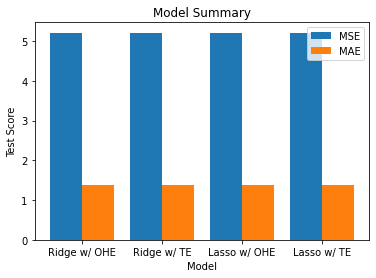

In [ ]:
# Generate lists to store the performance data
models = [ohe_ridge_best_pipe, te_ridge_best_pipe, ohe_lasso_best_pipe, te_lasso_best_pipe]
test_mses = []
test_maes = []

# Loop through, collecting the scores
for model in models: 
  test_mses.append(mean_squared_error(test_y, model.predict(test_x)))
  test_maes.append(mean_absolute_error(test_y, model.predict(test_x)))

# Visualize the results (https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/)
X = ['Ridge w/ OHE','Ridge w/ TE','Lasso w/ OHE','Lasso w/ TE']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, test_mses, 0.4, label = 'MSE')
plt.bar(X_axis + 0.2, test_maes, 0.4, label = 'MAE')

plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Test Score")
plt.title("Model Summary")
plt.legend()
plt.show()

(1.375, 1.38)

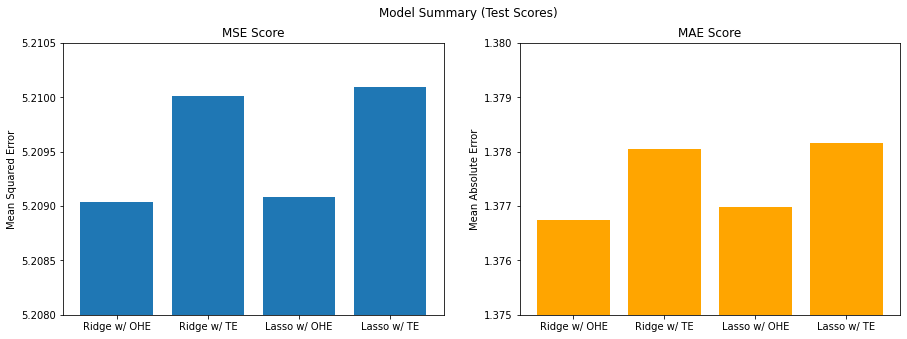

In [ ]:
# Zoomed in to highlight differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Model Summary (Test Scores)')

# MSES
ax1.bar(X, test_mses)
ax1.set_title('MSE Score')
ax1.set_ylabel('Mean Squared Error')
ax1.set_ylim(5.208, 5.2105)

# MAES
ax2.bar(X, test_maes, color="orange")
ax2.set_title('MAE Score')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_ylim(1.375, 1.38)

Notice, OHE seems like a much better option than TE across the board.

In [ ]:
print("Best Model According to MSE: {}".format(X[np.argmin(test_mses)]))
print("Best Model According to MAE: {}".format(X[np.argmin(test_maes)]))
print("MSE: {}".format(np.min(test_mses)))
print("MAE: {}".format(np.min(test_maes)))

Best Model According to MSE: Ridge w/ OHE
Best Model According to MAE: Ridge w/ OHE
MSE: 5.209041071260159
MAE: 1.3767476512706056


# Tree-Based Models 

Here we will look at Bagging, Random Forest, AdaBoost, and XGBoost Models

In [ ]:
# BAGGING (OHE)

# Set up search space for hyperparameters
# Estimators: deafult value is 10, experiment around that range
# Max samples: 3 values from 50%, 75%, and 100%
# Max Features: 3 values from 50%, 75%, and 100%

n_estimators = [5, 10, 15, 20]
max_samples = [0.5, 0.75, 1.0]
max_features = [0.5, 0.75, 1.0]
iteration = 0

oob_scores = {}

for n_estimator in n_estimators: 
  for max_sample in max_samples: 
    for max_feature in max_features: 
      print("Iteration {}...".format(iteration))
      bagging_pipe = make_pipeline(ohe_preprocess, BaggingRegressor(n_estimators=n_estimator, max_samples=max_sample, max_features=max_feature, oob_score=True))
      bagging_pipe.fit(dev_x, dev_y)
      rf = bagging_pipe.named_steps['baggingregressor']
      oob_scores[(n_estimator, max_sample, max_feature)] = rf.oob_score_
      iteration += 1

print("\n")

# Report the best parameters with the oob score
best_params = max(oob_scores, key=oob_scores.get)
print("Best Parameters: (n_estimators={}, max_samples={}, max_features={})".format(best_params[0], best_params[1], best_params[2]))
print("Best oob_score: {}\n".format(max(oob_scores.values())))

# Reconstruct and save the best model
bagging_pipe_ohe = make_pipeline(ohe_preprocess, BaggingRegressor(n_estimators=best_params[0], max_samples=best_params[1], max_features=best_params[2]))
bagging_pipe_ohe.fit(dev_x, dev_y)
print("Model Summary (w/ Optimal Params)")
print("Test MSE: {}".format(mean_squared_error(test_y, bagging_pipe_ohe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}\n".format(mean_absolute_error(test_y, bagging_pipe_ohe.predict(test_x))))

results = []

for key, value in oob_scores.items(): 
  results.append([key[0], key[1], key[2], value])

# Print a dataframe with all the results
results = pd.DataFrame(results)
results.columns = ["n_estimators", "max_samples", "max_features", "oob_score"]
results.sort_values(by="oob_score", inplace=True, ascending=False)
results

Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Iteration 13...
Iteration 14...
Iteration 15...
Iteration 16...
Iteration 17...
Iteration 18...
Iteration 19...
Iteration 20...
Iteration 21...
Iteration 22...
Iteration 23...
Iteration 24...
Iteration 25...
Iteration 26...
Iteration 27...
Iteration 28...
Iteration 29...
Iteration 30...
Iteration 31...
Iteration 32...
Iteration 33...
Iteration 34...
Iteration 35...


Best Parameters: (n_estimators=20, max_samples=0.5, max_features=0.75)
Best oob_score: 0.17355499518872974

Model Summary (w/ Optimal Params)
Test MSE: 5.575783014984305
Test MAE (ie. on average how much is our prediction of score off by): 1.4338553507520044



,n_estimators,max_samples,max_features,oob_score
28,20,0.50,0.75,0.173555
27,20,0.50,0.50,0.171149
29,20,0.50,1.00,0.171074
19,15,0.50,0.75,0.150870
18,15,0.50,0.50,0.149649
31,20,0.75,0.75,0.148923
30,20,0.75,0.50,0.145006
32,20,0.75,1.00,0.144422
20,15,0.50,1.00,0.142182
33,20,1.00,0.50,0.119754


In [ ]:
# BAGGING (TE)

# Set up search space for hyperparameters
# Estimators: deafult value is 10, experiment around that range
# Max samples: 3 values from 50%, 75%, and 100%
# Max Features: 3 values from 50%, 75%, and 100%

n_estimators = [5, 10, 15, 20]
max_samples = [0.5, 0.75, 1.0]
max_features = [0.5, 0.75, 1.0]
iteration = 0

oob_scores = {}

for n_estimator in n_estimators: 
  for max_sample in max_samples: 
    for max_feature in max_features: 
      print("Iteration {}...".format(iteration))
      bagging_pipe = make_pipeline(te_preprocess, BaggingRegressor(n_estimators=n_estimator, max_samples=max_sample, max_features=max_feature, oob_score=True))
      bagging_pipe.fit(dev_x, dev_y)
      rf = bagging_pipe.named_steps['baggingregressor']
      oob_scores[(n_estimator, max_sample, max_feature)] = rf.oob_score_
      iteration += 1

print("\n")

# Report the best parameters with the oob score
best_params = max(oob_scores, key=oob_scores.get)
print("Best Parameters: (n_estimators={}, max_samples={}, max_features={})".format(best_params[0], best_params[1], best_params[2]))
print("Best oob_score: {}\n".format(max(oob_scores.values())))

# Reconstruct and save the best model
bagging_pipe_te = make_pipeline(te_preprocess, BaggingRegressor(n_estimators=best_params[0], max_samples=best_params[1], max_features=best_params[2]))
bagging_pipe_te.fit(dev_x, dev_y)
print("Model Summary (w/ Optimal Params)")
print("Test MSE: {}".format(mean_squared_error(test_y, bagging_pipe_te.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}\n".format(mean_absolute_error(test_y, bagging_pipe_te.predict(test_x))))

results = []

for key, value in oob_scores.items(): 
  results.append([key[0], key[1], key[2], value])

# Print a dataframe with all the results
results = pd.DataFrame(results)
results.columns = ["n_estimators", "max_samples", "max_features", "oob_score"]
results.sort_values(by="oob_score", inplace=True, ascending=False)
results

Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Iteration 13...
Iteration 14...
Iteration 15...
Iteration 16...
Iteration 17...
Iteration 18...
Iteration 19...
Iteration 20...
Iteration 21...
Iteration 22...
Iteration 23...
Iteration 24...
Iteration 25...
Iteration 26...
Iteration 27...
Iteration 28...
Iteration 29...
Iteration 30...
Iteration 31...
Iteration 32...
Iteration 33...
Iteration 34...
Iteration 35...


Best Parameters: (n_estimators=20, max_samples=0.5, max_features=0.5)
Best oob_score: 0.17240947736708168

Model Summary (w/ Optimal Params)
Test MSE: 5.542389900378335
Test MAE (ie. on average how much is our prediction of score off by): 1.4341276474055495



,n_estimators,max_samples,max_features,oob_score
27,20,0.50,0.50,0.172409
28,20,0.50,0.75,0.171125
29,20,0.50,1.00,0.170465
18,15,0.50,0.50,0.153412
30,20,0.75,0.50,0.152952
31,20,0.75,0.75,0.149253
19,15,0.50,0.75,0.145882
32,20,0.75,1.00,0.143642
20,15,0.50,1.00,0.143467
21,15,0.75,0.50,0.122989


In [ ]:
# RANDOM FOREST (OHE)

# Set up search space for hyperparameters
# Estimators: deafult value is 100, experiment around that range
# Max depth: 3 values from 3, 5, 10 (number of features controlled by)

n_estimators = [100, 200, 300]
max_depths = [5, 10, 20]

iteration = 0

oob_scores = {}

for n_estimator in n_estimators: 
  for max_depth in max_depths: 
    print("Iteration {}...".format(iteration))
    forest_pipe = make_pipeline(ohe_preprocess, RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth, oob_score=True))
    forest_pipe.fit(dev_x, dev_y)
    rf = forest_pipe.named_steps['randomforestregressor']
    oob_scores[(n_estimator, max_depth)] = rf.oob_score_
    iteration += 1

print("\n")

# Report the best parameters with the oob score
best_params = max(oob_scores, key=oob_scores.get)
print("Best Parameters: (n_estimators={}, max_depth={})".format(best_params[0], best_params[1]))
print("Best oob_score: {}\n".format(max(oob_scores.values())))

# Reconstruct and save the best model
forest_pipe_ohe = make_pipeline(ohe_preprocess, RandomForestRegressor(n_estimators=best_params[0], max_depth=best_params[1]))
forest_pipe_ohe.fit(dev_x, dev_y)
print("Model Summary (w/ Optimal Params)")
print("Test MSE: {}".format(mean_squared_error(test_y, forest_pipe_ohe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}\n".format(mean_absolute_error(test_y, forest_pipe_ohe.predict(test_x))))

results = []

for key, value in oob_scores.items(): 
  results.append([key[0], key[1], value])

# Print a dataframe with all the results
results = pd.DataFrame(results)
results.columns = ["n_estimators", "max_depth", "oob_score"]
results.sort_values(by="oob_score", inplace=True, ascending=False)
results

Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...


Best Parameters: (n_estimators=300, max_depth=10)
Best oob_score: 0.25221246090815497

Model Summary (w/ Optimal Params)
Test MSE: 5.184200804858357
Test MAE (ie. on average how much is our prediction of score off by): 1.3499292393161733



,n_estimators,max_depth,oob_score
7,300,10,0.252212
4,200,10,0.251392
6,300,5,0.250395
3,200,5,0.250325
1,100,10,0.250134
0,100,5,0.249982
8,300,20,0.233155
5,200,20,0.231633
2,100,20,0.224133


In [ ]:
# RANDOM FOREST (TE)

# Set up search space for hyperparameters
# Estimators: deafult value is 100, experiment around that range
# Max depth: 3 values from 3, 5, 10 (number of features controlled by)

n_estimators = [100, 200, 300]
max_depths = [5, 10, 20]

iteration = 0

oob_scores = {}

for n_estimator in n_estimators: 
  for max_depth in max_depths: 
    print("Iteration {}...".format(iteration))
    forest_pipe = make_pipeline(te_preprocess, RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth, oob_score=True))
    forest_pipe.fit(dev_x, dev_y)
    rf = forest_pipe.named_steps['randomforestregressor']
    oob_scores[(n_estimator, max_depth)] = rf.oob_score_
    iteration += 1

print("\n")

# Report the best parameters with the oob score
best_params = max(oob_scores, key=oob_scores.get)
print("Best Parameters: (n_estimators={}, max_depth={})".format(best_params[0], best_params[1]))
print("Best oob_score: {}\n".format(max(oob_scores.values())))

# Reconstruct and save the best model
forest_pipe_te = make_pipeline(te_preprocess, RandomForestRegressor(n_estimators=best_params[0], max_depth=best_params[1]))
forest_pipe_te.fit(dev_x, dev_y)
print("Model Summary (w/ Optimal Params)")
print("Test MSE: {}".format(mean_squared_error(test_y, forest_pipe_te.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}\n".format(mean_absolute_error(test_y, forest_pipe_te.predict(test_x))))

results = []

for key, value in oob_scores.items(): 
  results.append([key[0], key[1], value])

# Print a dataframe with all the results
results = pd.DataFrame(results)
results.columns = ["n_estimators", "max_depth", "oob_score"]
results.sort_values(by="oob_score", inplace=True, ascending=False)
results

Iteration 0...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...


Best Parameters: (n_estimators=300, max_depth=10)
Best oob_score: 0.2519201897869686

Model Summary (w/ Optimal Params)
Test MSE: 5.186423175252335
Test MAE (ie. on average how much is our prediction of score off by): 1.350017653781574



,n_estimators,max_depth,oob_score
7,300,10,0.251920
4,200,10,0.251788
3,200,5,0.250242
6,300,5,0.250217
0,100,5,0.249794
1,100,10,0.249749
8,300,20,0.234376
5,200,20,0.232342
2,100,20,0.223488


In [ ]:
# XGB (OHE) 

# Hyperparameters
# Learning rate is defaulted at 0.3, so let's explore that range
# L2 regularization is defaulted at 1 so let's explore above (for XGB is appears l2 regularization is controlled by lambda)
# L1 regularization is defaulted at 0 (for XGB this is controlled by alpha)
learning_rate_hyperparam = [0.1, 0.3, 0.5]

# Set up the grid search grid
gradient_param_grid = [{"learning_rate": learning_rate_hyperparam}]

# Make a new pipeline (by default GridSearchCV uses 5 fold)
xgb_pipe = make_pipeline(ohe_preprocess, 
                     GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=gradient_param_grid))

# Train
xgb_pipe.fit(dev_x, dev_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['assists', 'bonus', 'bps',
                                                   'clean_sheets', 'creativity',
                                                   'element', 'goals_conceded',
                                                   'goals_scored', 'ict_index',
                                                   'influence', 'minutes',
                                                   'own_goals',
                                                   'penalties_missed',
                                                   'penalties_saved',
                                                   'red_cards', 'saves',
                                                   'selected', 'team_a_score',
                                                   'team_h_score', 'threat'

Text(0.5, 0, 'Learning Rate Parameter')

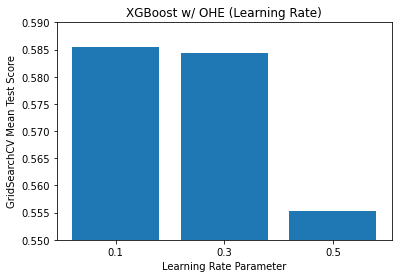

In [186]:
# Results from grid search
scores = xgb_pipe[1].cv_results_['mean_test_score']

plt.bar(["0.1", "0.3", "0.5"], scores)
plt.ylim(0.55, 0.59)
plt.title('XGBoost w/ OHE (Learning Rate)')
plt.ylabel('GridSearchCV Mean Test Score')
plt.xlabel('Learning Rate Parameter')

In [199]:
# Test scores from testing set
xgb_ohe_pipe = make_pipeline(ohe_preprocess, xgb_pipe[1].best_estimator_)
xgb_ohe_pipe.fit(dev_x, dev_y)

print("Optimal XGB Learning Rate: {}\n".format(xgb_ohe_pipe[1].learning_rate))
print("Test MSE: {}".format(mean_squared_error(test_y, xgb_ohe_pipe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}\n".format(mean_absolute_error(test_y, xgb_ohe_pipe.predict(test_x))))

Optimal XGB Learning Rate: 0.1

Test MSE: 6.694862187548119
Test MAE (ie. on average how much is our prediction of score off by): 1.1996099163373197



In [200]:
# XGB (TE) 

# Hyperparameters
# Learning rate is defaulted at 0.3, so let's explore that range
# L2 regularization is defaulted at 1 so let's explore above (for XGB is appears l2 regularization is controlled by lambda)
# L1 regularization is defaulted at 0 (for XGB this is controlled by alpha)
learning_rate_hyperparam = [0.1, 0.3, 0.5]

# Set up the grid search grid
gradient_param_grid = [{"learning_rate": learning_rate_hyperparam}]

# Make a new pipeline (by default GridSearchCV uses 5 fold)
xgb_pipe = make_pipeline(te_preprocess, 
                     GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=gradient_param_grid))

# Train
xgb_pipe.fit(dev_x, dev_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['assists', 'bonus', 'bps',
                                                   'clean_sheets', 'creativity',
                                                   'element', 'goals_conceded',
                                                   'goals_scored', 'ict_index',
                                                   'influence', 'minutes',
                                                   'own_goals',
                                                   'penalties_missed',
                                                   'penalties_saved',
                                                   'red_cards', 'saves',
                                                   'selected', 'team_a_score',
                                                   'team_h_score', 'threat'

Text(0.5, 0, 'Learning Rate Parameter')

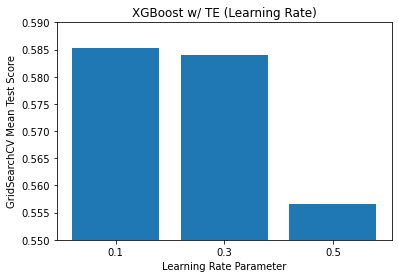

In [202]:
# Results from grid search
scores = xgb_pipe[1].cv_results_['mean_test_score']

plt.bar(["0.1", "0.3", "0.5"], scores)
plt.ylim(0.55, 0.59)
plt.title('XGBoost w/ TE (Learning Rate)')
plt.ylabel('GridSearchCV Mean Test Score')
plt.xlabel('Learning Rate Parameter')

In [204]:
# Test scores from testing set
xgb_te_pipe = make_pipeline(te_preprocess, xgb_pipe[1].best_estimator_)
xgb_te_pipe.fit(dev_x, dev_y)

print("Optimal XGB Learning Rate: {}\n".format(xgb_te_pipe[1].learning_rate))
print("Test MSE: {}".format(mean_squared_error(test_y, xgb_te_pipe.predict(test_x))))
print("Test MAE (ie. on average how much is our prediction of score off by): {}\n".format(mean_absolute_error(test_y, xgb_ohe_pipe.predict(test_x))))

Optimal XGB Learning Rate: 0.1

Test MSE: 6.651747677462403
Test MAE (ie. on average how much is our prediction of score off by): 1.1950931581378639



# Final Results

Best Models: 


1.   Ridge Regression w/ OHE (alpha=0.0005809855079265689)
2.   Lasso Regression w/OHE (alpha=0.0 005809855079265689) 
3. Bagging w/ OHE (ax_features=0.75, max_samples=0.5, n_estimators=20) 
4. Random Forest w/ OHE (max_depth=10, n_estimators=300) 
5. XGBoost w/ TE (learning rate=0.1)



In [215]:
# Make predictions on unseen test
ohe_ridge = ohe_ridge_best_pipe.predict(test_x)
ohe_lasso = ohe_lasso_best_pipe.predict(test_x)
ohe_bagging = bagging_pipe_ohe.predict(test_x)
ohe_forest = forest_pipe_ohe.predict(test_x)
te_xgb = xgb_te_pipe.predict(test_x)

preds = [ohe_ridge, ohe_lasso, ohe_bagging, ohe_forest, te_xgb]

models = ["Ridge", "Lasso", "Bagging", "Random Forests", "XGBoost"]
mse_scores = [mean_squared_error(test_y, x) for x in preds]
mae_scores = [mean_absolute_error(test_y, x) for x in preds]

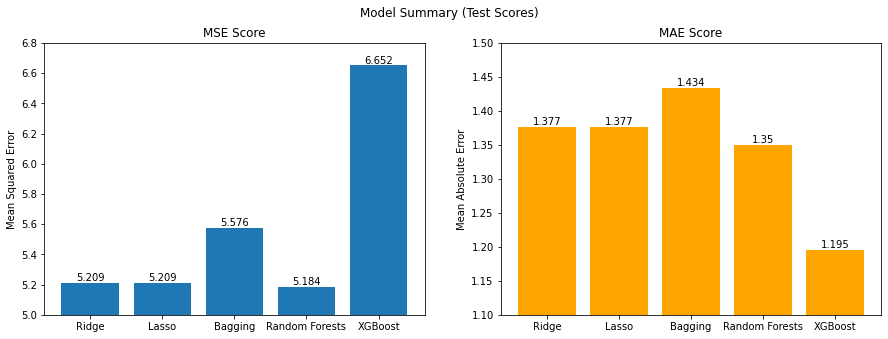

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Summary (Test Scores)')

# MSES
ax1.bar(models, mse_scores)
ax1.set_ylim(5, 6.8)
ax1.set_title('MSE Score')
ax1.set_ylabel('Mean Squared Error')
for i in range(len(mse_scores)):
    ax1.annotate(str(round(mse_scores[i], 3)), xy=(models[i],mse_scores[i]), ha='center', va='bottom')

# MAES
ax2.bar(models, mae_scores, color="orange")
ax2.set_ylim(1.1, 1.5)
ax2.set_title('MAE Score')
ax2.set_ylabel('Mean Absolute Error')
for i in range(len(mae_scores)):
    ax2.annotate(str(round(mae_scores[i], 3)), xy=(models[i],mae_scores[i]), ha='center', va='bottom')
